# Training the projection layer

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoConfig
from transformers import AutoModelForCausalLM
from PIL import Image

In [2]:
from pathlib import Path
base_path = Path("img_emb/")

In [7]:
tensor_list = []
for i in range(5):
    file_path = base_path/f"embeddings_batch{i}.pth"
    tensor_list.append(torch.load(file_path))
embs = torch.concat(tensor_list, axis=0)
# torch.save(embs,"img_embeddings.pth")\

In [8]:
embs.shape

torch.Size([160, 512])

In [4]:
import json

with open("./image_names.json", 'r') as file:
    image_names = json.load(file)

In [9]:
data = dict(zip(image_names[:160], embs))

In [11]:
torch.save(data,"sample_data.pth")

In [4]:
embs = torch.load("img_embeddings.pth")
embs.shape

torch.Size([118287, 512])

In [5]:
root_dir = Path("train2017/")
image_names = [f for f in os.listdir(root_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

In [6]:
from PIL import Image

#### ML Projector layer is taken from open source code.
##### Courtesy: https://github.com/sshh12/multi_token/blob/81ee75cd4435ebd5c7c7c3cf42c136c4053320fb/multi_token/modalities/projectors.py

In [7]:
def build_patch_mlp_projector(
    input_hidden_size: int, lm_hidden_size: int, num_layers: int
) -> nn.Module:
    modules = [nn.Linear(input_hidden_size, lm_hidden_size, bias=False)]
    for _ in range(1, num_layers):
        modules.append(nn.GELU())
        modules.append(nn.Linear(lm_hidden_size, lm_hidden_size, bias=False))
    return nn.Sequential(*modules)


class _MLPVectorProjector(nn.Module):
    def __init__(
        self, input_hidden_size: int, lm_hidden_size: int, num_layers: int, width: int
    ):
        super(_MLPVectorProjector, self).__init__()
        self.mlps = nn.ModuleList()
        for _ in range(width):
            mlp = [nn.Linear(input_hidden_size, lm_hidden_size, bias=False)]
            for _ in range(1, num_layers):
                mlp.append(nn.GELU())
                mlp.append(nn.Linear(lm_hidden_size, lm_hidden_size, bias=False))
            self.mlps.append(nn.Sequential(*mlp))

    def forward(self, x):
        return torch.cat([mlp(x) for mlp in self.mlps], dim=-2)


def build_mlp_vector_projector(
    input_hidden_size: int, lm_hidden_size: int, num_layers: int, num_tokens: int
):
    return _MLPVectorProjector(
        input_hidden_size, lm_hidden_size, num_layers, num_tokens
    )

#### Write custom model - with projection Layer and Phi-2 model

In [8]:
# model_name = "susnato/phi-2"
# tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
# phi2Model = AutoModelForCausalLM.from_pretrained(model_name).to("cuda")
# token_embedding = phi2Model.get_submodule('model.embed_tokens')


In [9]:
# tokens = tokenizer.encode("What is language modelling ?\n", return_tensors="pt").to("cuda")
# generation = phi2Model.generate(
#     inputs_embeds = token_embedding(tokens),
#     # attention_mask = torch.ones(1, len(tokens)).to("cuda"),
#     max_new_tokens=20)
# print(tokenizer.batch_decode(generation))

In [10]:
# tokens = tokenizer.encode("What is language modelling ?\nLanguage modelling is a branch of natural language processing (NLP) that focuses on the statistical analysis of", return_tensors="pt").to("cuda")
# outputs = phi2Model.forward(
#     inputs_embeds = token_embedding(tokens))
# print(tokenizer.batch_decode(outputs.logits.argmax(-1)[0]))

In [11]:
#     # \n     \n    \"\"\"
# generation = phi2Model.generate(
#     **tokenizer("What is language modelling ?", return_tensors="pt").to("cuda"), 
#     max_new_tokens=1)
# print(tokenizer.batch_decode(generation[0]))

In [8]:
model_name = "microsoft/phi-2"
phi2 = AutoModelForCausalLM.from_pretrained(
            model_name,
            trust_remote_code=True,
            # torch_dtype = torch.float16
        ).to("cuda")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
from transformers import AutoModelForCausalLM


class ImageWithPhiLayer(nn.Module):
    def __init__(self, 
                 clip_emb:int = 512, 
                 token_emb: int = 2560,
                 projection_n_tokens: int = 4,
                 projection_n_layers: int = 1
                ):
        super().__init__()       
        self.projection_n_tokens = projection_n_tokens
        self.ll1 = build_mlp_vector_projector(
            clip_emb, token_emb, 1, self.projection_n_tokens).to("cuda")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
        self.vocab_size = len(tokenizer)
        self.tokenizer.pad_token = tokenizer.eos_token  
        self.phi2Model = phi2
        self.token_embedding = self.phi2Model.get_submodule('model.embed_tokens')
        for name, param in self.phi2Model.named_parameters():
                param.requires_grad = False
                
    def generate_text_from_embeddings(self, logits):
        # Apply softmax to obtain probabilities
        probabilities = logits.softmax(dim=2)  # Softmax along the last dimension

        # Find the index of the class with the highest probability for each token in each sequence
        predicted_indices = torch.argmax(probabilities, dim=2)

        # Decode each sequence of predicted indices back into text
        predicted_texts = [self.tokenizer.decode(seq) for seq in predicted_indices]
        #print(predicted_texts)
        return predicted_texts

        
    def forward(self, x, captions):
        x = self.ll1(x)
        input_captions = []
        target_captions = [] 

        for caption in captions:
            ip_caption = torch.concat(
                (
                    torch.tensor([self.tokenizer.bos_token_id]).to("cuda"), 
                    caption,
                )
            )
            tg_caption = torch.concat(
                (
                    caption,
                    torch.tensor([self.tokenizer.eos_token_id]).to("cuda"), 
                )
            )
            input_captions.append(ip_caption.unsqueeze(0))
            target_captions.append(tg_caption.unsqueeze(0))
        input_captions = torch.concat(input_captions, axis=0)
        target_captions = torch.concat(target_captions, axis=0)
        
        caption_token_embeddings = self.token_embedding(input_captions)   
        inputs = torch.concat((x, caption_token_embeddings), axis=-2)

        
        outputs = self.phi2Model(inputs_embeds=inputs)
        predictions = self.generate_text_from_embeddings(outputs.logits[:, self.projection_n_tokens:, :])
        # print(outputs.logits[:, self.projection_n_tokens :, :].shape)
        # print(target_captions.shape)
        loss = F.cross_entropy(
            outputs.logits[:, self.projection_n_tokens: , :].reshape(-1, outputs.logits.size(-1)), 
            target_captions.reshape(-1),
            ignore_index=50256,
        )
        return loss, predictions

#### Prepare Data - Use Dataloader

In [10]:

import pandas as pd
import json

annFile = f'annotations/captions_train2017.json'
with open(annFile, 'r') as f:
    annotations_data = json.load(f)
captions = pd.DataFrame(annotations_data["annotations"])
img_id_mapping = pd.DataFrame(annotations_data["images"], columns=['file_name', 'id'])
captions_df = captions.merge(img_id_mapping, left_on="image_id",  right_on="id", )

In [11]:
def get_captions_by_image_name(image_name):
    return captions_df.query("file_name == @image_name").sample(1)['caption'].values[0]
    
get_captions_by_image_name(image_names[42])

'A futon type bed is in a room with a wooden floor.'

In [12]:
from torch.utils.data import Dataset, DataLoader

class ImageEmbCaptionDataset(Dataset):
    def __init__(self, imageIDs, imageEmbeddings, tokenizer,
                 caption_max_len = 50
                ):
        self.imageIDs = imageIDs
        self.imageEmbeddings = imageEmbeddings
        self.tokenizer = tokenizer
        self.caption_max_len = caption_max_len

    def __len__(self):
        return len(self.imageIDs)

    def __getitem__(self, index):
        image_name = self.imageIDs[index]
        image_embedding = self.imageEmbeddings[index : index + 1]
        caption_text = get_captions_by_image_name(image_name)
        padded_caption_tokens = tokenizer.encode(
            caption_text,
            add_special_tokens=True,
            padding='max_length', 
            truncation=True, 
            max_length=self.caption_max_len
        )
        return {
            'image_name': image_name, 
            'caption_text': caption_text, 
            'image_embedding': image_embedding, 
            'caption_tokens': torch.tensor(padded_caption_tokens)
        }

In [13]:
model_name = "microsoft/phi-2"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

custom_dataset = ImageEmbCaptionDataset(
    image_names,
    embs, 
    tokenizer
)
custom_dataloader = DataLoader(custom_dataset, batch_size=128, shuffle=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


#### Create and train the model

In [14]:
model = ImageWithPhiLayer()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:

# Training loop
num_epochs = 200
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

for epoch in range(num_epochs):
    model.train()
    for ix, batch in enumerate(custom_dataloader):
        optimizer.zero_grad()
        embeddings = batch['image_embedding'].to('cuda')
        captions = batch['caption_tokens'].to('cuda')
        loss, predictions = model(embeddings, captions)
        
        # Backward pass and optimization
        
        loss.backward()
        optimizer.step()
        if ix % 100 != 0 :
            continue
        print("------------captions text = -------------------")
        print(batch['caption_text'][0])
        print("------------predicted text = -------------------")
        cleaned_predictions = predictions[0].rstrip('\n')
        print(cleaned_predictions)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

    torch.save(
        model.ll1.state_dict(), 
        "proj_layer.pth"
    )

------------captions text = -------------------
A brown cat is sitting on a bench near bushes.
------------predicted text = -------------------

 newfield is a on a white in a.
TheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheThe



TheTheTheTheTheThe

TheTheTheThe





The
------------captions text = -------------------
A plate of food served with fries and a pickle
------------predicted text = -------------------
A group of food is at a and a drinkle.ATheINTheTheINQ
INInstInst

InstInstInstInstInst



Inst

INInstInst
IN

Inst
------------captions text = -------------------
A person skiing down a snow covered slope.
------------predicted text = -------------------
A man sitting on a hill covered mountain. A
------------captions text = -------------------
A crowded market area of one of the east Asian countries.
------------predicted text = -------------------
A man street with with people of the many coast countries. A





The
------------captions text = -------------------


# inference

In [15]:
path_to_layer_file = 'proj_layer.pth'
loaded_layer = torch.load(path_to_layer_file)
model.ll1.load_state_dict(loaded_layer)

<All keys matched successfully>

In [37]:
print(batch['caption_text'][:2])

['A bouquet of different types of flowers and green leaves in a multicolored vase.', 'A Church with some tents with items for sale in front of it.']


In [205]:


# Define the file path for the JSON file
file_path = 'iamge_names.json'

# Save the data to the JSON file
with open(file_path, 'w') as file:
    json.dump(image_names, file)

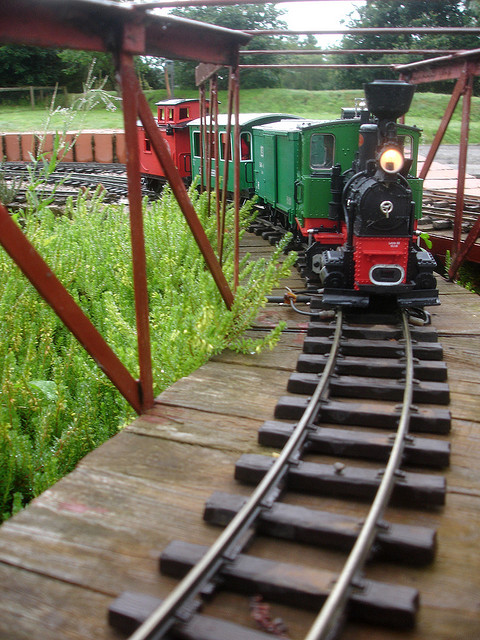

In [198]:
Image.open(os.path.join(root_dir, image_names[22]))

In [199]:
# custom_dataset = ImageEmbCaptionDataset(
#     image_names,
#     embs, 
#     tokenizer
# )
batch = custom_dataset[22]
embeddings = batch['image_embedding'].to('cuda').unsqueeze(0)
captions = batch['caption_tokens'].to('cuda').unsqueeze(0)

In [200]:
batch['caption_text']

'Small toy train engine preparing to ride over a bridge. '

In [201]:
model.tokenizer.batch_decode(batch['caption_tokens'][:3])

['Small', ' toy', ' train']

In [203]:
proj_out = model.ll1(embeddings)

caption_token_embeddings = model.token_embedding(
    
    torch.tensor([model.tokenizer.eos_token_id]).to("cuda").unsqueeze(0))
#print('---------caption_token_embeddings.shape --------------------------------------')
#print(caption_token_embeddings.shape)  #[8, 1024, 2560]      


inputs = torch.concat((proj_out,  
                       caption_token_embeddings), axis=-2)

model.tokenizer.batch_decode(model.phi2Model.generate(
    inputs_embeds=inputs, max_new_tokens=200,
    bos_token_id=model.tokenizer.bos_token_id, 
    eos_token_id=model.tokenizer.eos_token_id
))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['<|endoftext|>A man is holding a plate of food in his hand. \nHe is standing in front of a table. \nThere is a plate of food on the table. \nThere is a bowl of soup on the table. \nThere is a glass of water on the table. \nThere is a fork on the table. \nThere is a knife on the table. \nThere is a napkin on the table. \nThere is a plate on the table. \nThere is a bowl on the table. \nThere is a glass on the table. \nThere is a spoon on the table. \nThere is a fork on the table. \nThere is a knife on the table. \nThere is a napkin on the table. \nThere is a plate on the table. \nThere is a bowl on the table. \nThere is a glass on the table. \nThere is a spoon on the table']

In [106]:
embeddings.shape

torch.Size([1, 1, 512])

# old version

In [ ]:
# class ImageWithPhiLayer(nn.Module):
#     def __init__(self, 
#                  clip_emb:int = 512, 
#                  token_emb: int = 2560,
#                  projection_n_tokens: int = 2,
#                  projection_n_layers: int = 2
#                 ):
#         super(ImageWithPhiLayer, self).__init__()
#         self.projection_n_tokens = projection_n_tokens
#         self.ll1 = build_mlp_vector_projector(
#             clip_emb, token_emb, projection_n_layers, self.projection_n_tokens).to("cuda")
        
#         self.tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
#         self.before_emb_token = torch.tensor(self.tokenizer.encode("Image:")).to("cuda")
#         self.after_emb_token = torch.tensor(self.tokenizer.encode("Caption:")).to("cuda")
#         self.vocab_size = len(self.tokenizer)
#         self.phi2Model = phi2
#         self.token_embedding = self.phi2Model.get_input_embeddings()
#         self.token_embedding.requires_grad = False
#         for name, param in self.phi2Model.named_parameters():
#                 param.requires_grad = False
        
#     def forward(self, x, captions):
#         x = self.ll1(x)
#         batch_size = x.shape[0]
#         caption_token_embeddings = self.token_embedding(captions)
#         inputs = torch.concat(
#             (
#                 self.token_embedding(self.before_emb_token).unsqueeze(0).repeat(batch_size, 1, 1),
#                 x, 
#                 self.token_embedding(self.after_emb_token).unsqueeze(0).repeat(batch_size, 1, 1),
#             ), 
#             axis=-2)
#         loss = 0
#         counter = 0
#         for embeddings, token in zip(caption_token_embeddings.permute(1, 0, 2), captions.permute(1, 0)):
#             inputs = torch.concat(
#             (
#                 inputs,
#                 embeddings.unsqueeze(1)
#             ), 
#             axis=-2)
#             # print("inputs", inputs.shape)
#             # print(captions)
#             outputs = self.phi2Model.generate(
#                 inputs_embeds=inputs, max_new_tokens=1,
#                 attention_mask=torch.ones(inputs.shape[0], inputs.shape[1]).to("cuda"),
#                 output_scores=True, return_dict_in_generate = True,
#                 pad_token_id=50256,
#                 bos_token_id=self.tokenizer.bos_token_id, 
#                 eos_token_id=self.tokenizer.eos_token_id
#             )
#             iloss = F.cross_entropy(
#                     outputs.scores[0],
#                     token,
#                     ignore_index=50256,
#                     label_smoothing=0.1
#                 )
#             if torch.isnan(iloss):
#                 break
#             loss += iloss
#             counter += 1
#         return loss / counter 


# # Training loop
# num_epochs = 10
# # optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
# torch.set_grad_enabled(True)
# # optimizer = torch.optim.Adam(filter(lambda param: param.requires_grad, 
# #                                     model.parameters()), 
# #                             lr=1e-5, eps=1e-9) 

# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, eps=1e-9) 


# for epoch in range(num_epochs):
#     model.train()
#     for idx, batch in enumerate(custom_dataloader):
#         if idx % 5 == 0:
#             embeddings = batch['image_embedding'].to('cuda')
#             captions = batch['caption_tokens'].to("cuda")
#             print("Ground Truth")
#             print(' '.join(tokenizer.batch_decode([i.item() for i in captions[0] if i.item() != 50256])))
#             embeddings = embeddings[:1]
#             embeddings = model.ll1(embeddings)
#             print("Prediction")
#             for _ in range(20):
#                 loss = model.phi2Model.generate(
#                     inputs_embeds=embeddings,
#                     output_scores=True,
#                     max_new_tokens=1,
#                     attention_mask=torch.ones(
#                         embeddings.shape[0], embeddings.shape[1]).to("cuda"),
#                     pad_token_id=50256,
#                     return_dict_in_generate = True,
#                     bos_token_id=model.tokenizer.bos_token_id, 
#                     eos_token_id=model.tokenizer.eos_token_id
#                 )
#                 next_token = loss.scores[0].argmax(-1).unsqueeze(dim=0)
#                 print(tokenizer.batch_decode(next_token)[0], end='')
                
#                 embeddings = torch.concat(
#                     (
#                         embeddings,
#                         model.token_embedding(torch.tensor(next_token))
#                     ),
#                 axis=1)
#             print("\n")
        
#         optimizer.zero_grad()
#         embeddings = batch['image_embedding'].to('cuda')
#         captions = batch['caption_tokens'].to('cuda')
#         loss = model(embeddings, captions)
#         loss.requires_grad = True
        
#         # Backward pass and optimization
#         loss.backward(retain_graph=True)
#         optimizer.step()
#         if idx % 10 == 0: print(f"Loss: {loss.item()}")


#     print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")